## Circadian rhythms analysis of Wikipedia revisions

In [1]:
import statsmodels
statsmodels.__version__

'0.12.2'

In [17]:
import numpy as np
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter, NullFormatter
from scipy import stats
from statsmodels.stats.weightstats import ztest

import sys
import pytz
sys.path.insert(1, "../src")
from tools import add_dates, group_by_weekdayhour, plot_circadian, between_dates, plot_circadian_multiple_countries, plot_circadian_first_wave, euclidean_distance_cr

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
revs_de = add_dates(pd.read_csv("../data/revisions_countrywide/dewiki.csv"))
revs_de_original = add_dates(pd.read_csv("../data/revisions_countrywide/dewiki.csv"), tz="default")
revs_it = add_dates(pd.read_csv("../data/revisions_countrywide/itwiki.csv"))
revs_it_original = add_dates(pd.read_csv("../data/revisions_countrywide/itwiki.csv"), tz="default")
revs_se = add_dates(pd.read_csv("../data/revisions_countrywide/sewiki.csv"))
revs_hu = add_dates(pd.read_csv("../data/revisions_countrywide/huwiki.csv"))
revs_dict = {"DE": revs_de, "IT": revs_it, "HU": revs_hu, }#"SE": revs_se}

In [4]:
revs_de

,y,m,d,h,c,date,weekday
0,2018,1,1,0,987,2018-01-01 01:00:00+01:00,0
1,2018,1,1,1,1024,2018-01-01 02:00:00+01:00,0
2,2018,1,1,2,766,2018-01-01 03:00:00+01:00,0
3,2018,1,1,3,681,2018-01-01 04:00:00+01:00,0
4,2018,1,1,4,465,2018-01-01 05:00:00+01:00,0
...,...,...,...,...,...,...,...
29633,2021,5,19,17,1506,2021-05-19 19:00:00+02:00,2
29634,2021,5,19,18,1105,2021-05-19 20:00:00+02:00,2
29635,2021,5,19,19,1300,2021-05-19 21:00:00+02:00,2
29636,2021,5,19,20,1107,2021-05-19 22:00:00+02:00,2


#### Circadian rhythms for Sweden - too small data?

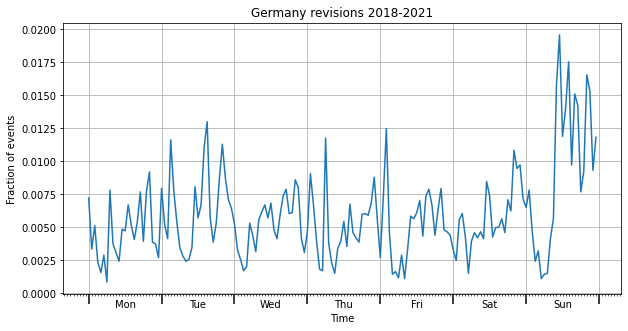

In [5]:
plot_circadian(group_by_weekdayhour(revs_se), "Germany revisions 2018-2021")

## Comparison between Covid and non-Covid time frames

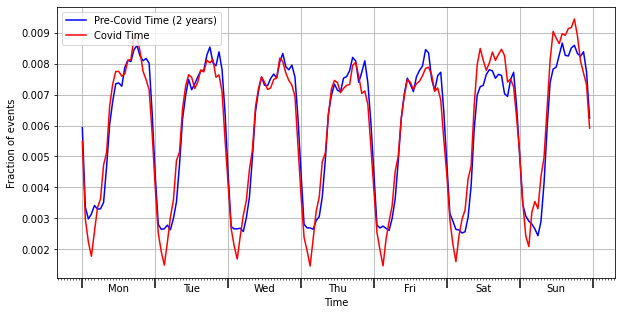

In [7]:
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.grid()

ax1.plot(list(range(168)), list(group_by_weekdayhour(between_dates(revs_de, "2018-01-01", "2020-02-01"))["counts"]),
         color="blue", label="Pre-Covid Time (2 years)")
ax1.plot(list(range(168)), list(group_by_weekdayhour(between_dates(revs_de, "2020-02-01"))["counts"]),
         color="red", label="Covid Time")
ax1.xaxis.set_major_locator(MultipleLocator(24))
ax1.xaxis.set_minor_locator(MultipleLocator(1))

days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
def tick(x,pos):
    if x % 24 == 12:
        return days[int(x)//24]
    else:
        return ""
    
ax1.xaxis.set_major_formatter(NullFormatter())
ax1.xaxis.set_minor_formatter(FuncFormatter(tick))
ax1.tick_params(which="major", axis="x", length=10, width=1.5)
ax1.set_xlabel("Time")
ax1.set_ylabel("Fraction of events")
ax1.legend(loc='upper left')
plt.show()

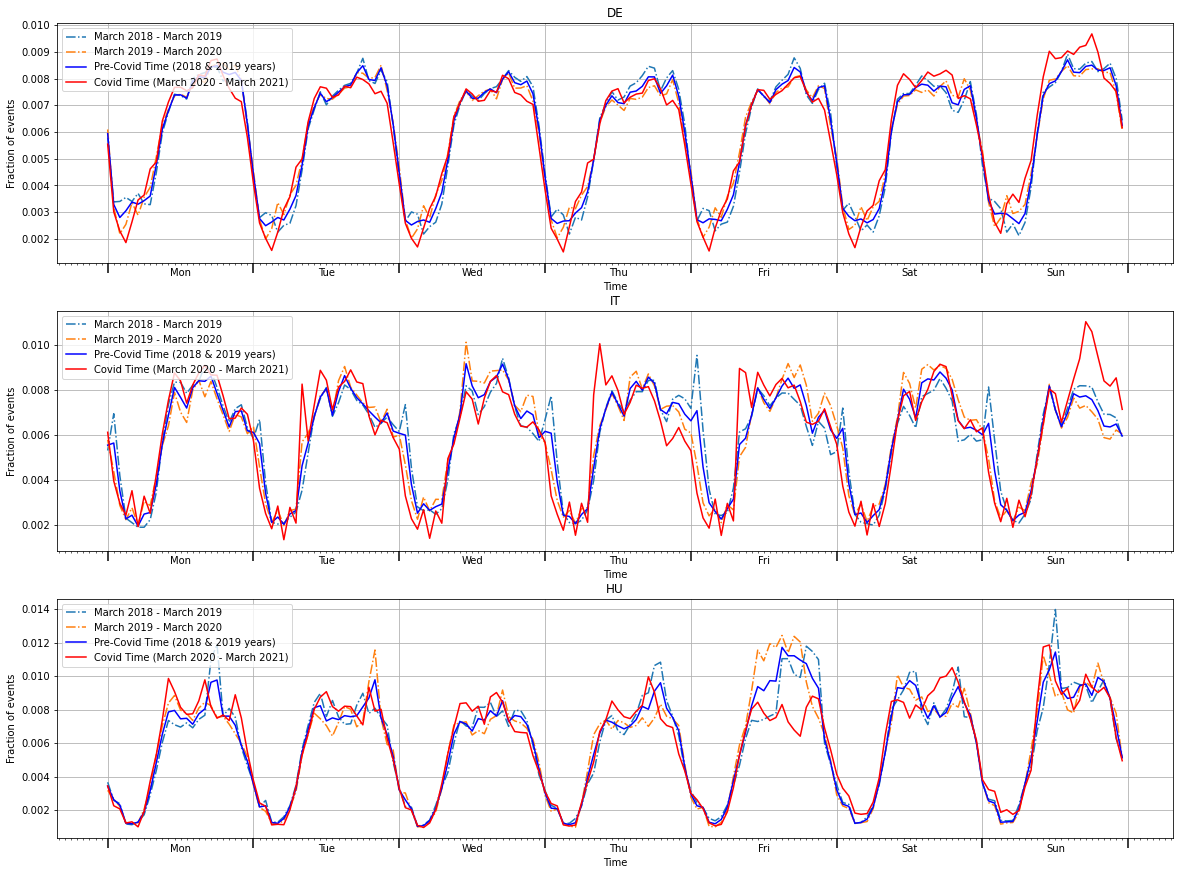

In [8]:
plot_circadian_multiple_countries(revs_dict) # all data

## March-May 2020 (first wave)

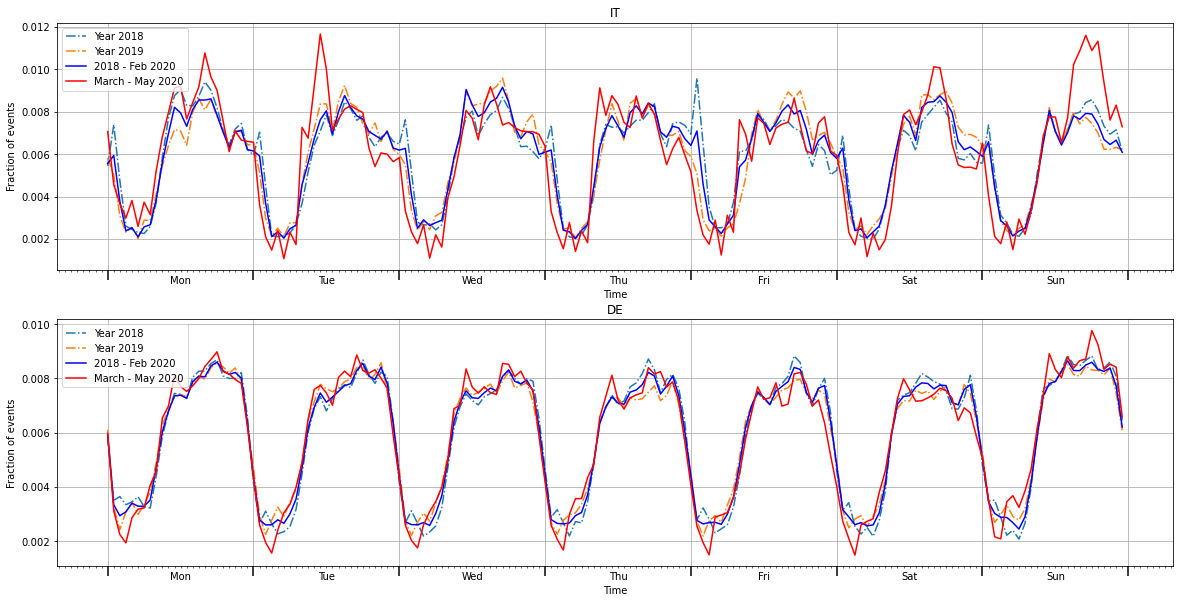

In [9]:
plot_circadian_first_wave({"IT": revs_it, "DE": revs_de})

In [10]:
from itertools import combinations
frames = {"2018": ("2018-03-01", "2019-03-01"), "2019": ("2019-03-01", "2020-03-01"), 
         "covid": ("2020-03-01", "2021-03-01")}


# list(group_by_weekdayhour(between_dates(df, "2020-03-01", "2021-03-01"))["counts"])

In [27]:
list(combinations(frames.items(), 2))

[(('2018', ('2018-03-01', '2019-03-01')),
  ('2019', ('2019-03-01', '2020-03-01'))),
 (('2018', ('2018-03-01', '2019-03-01')),
  ('covid', ('2020-03-01', '2021-03-01'))),
 (('2019', ('2019-03-01', '2020-03-01')),
  ('covid', ('2020-03-01', '2021-03-01')))]

In [34]:
print('Kolmogorov-Smirnov test')
for country, df in revs_dict.items():
    for (year1, (s1, e1)), (year2, (s2, e2)) in list(combinations(frames.items(), 2)):
        samples1 = list(group_by_weekdayhour(between_dates(df, s1, e1))["counts"])
        samples2 = list(group_by_weekdayhour(between_dates(df, s2, e2))["counts"])
        st, pval = stats.ks_2samp(samples1, samples2)
        print(f"C: {country} -- {year1}-{year2}: p value: {pval:.5f}; p-val < 5%? - {pval < 0.05}; ")

Kolmogorov-Smirnov test
C: DE -- 2018-2019: p value: 0.35683; p-val < 5%? - False; 
C: DE -- 2018-covid: p value: 0.35683; p-val < 5%? - False; 
C: DE -- 2019-covid: p value: 0.86563; p-val < 5%? - False; 
C: IT -- 2018-2019: p value: 0.43231; p-val < 5%? - False; 
C: IT -- 2018-covid: p value: 0.06477; p-val < 5%? - False; 
C: IT -- 2019-covid: p value: 0.43231; p-val < 5%? - False; 
C: HU -- 2018-2019: p value: 0.86563; p-val < 5%? - False; 
C: HU -- 2018-covid: p value: 0.69745; p-val < 5%? - False; 
C: HU -- 2019-covid: p value: 0.29045; p-val < 5%? - False; 


In [20]:
print('Pearson Correlation')
for country, df in revs_dict.items():
    for (year1, (s1, e1)), (year2, (s2, e2)) in list(combinations(frames.items(), 2)):
        samples1 = list(group_by_weekdayhour(between_dates(df, s1, e1))["counts"])
        samples2 = list(group_by_weekdayhour(between_dates(df, s2, e2))["counts"])
        coeff = np.corrcoef(samples1, samples2)[0, 1]
#         tstat, pval = ztest(samples1, samples2)
#         print(f"C: {country} -- {year1}-{year2}: {pval}; {pval < 0.05}; ")
#         print(f"C: {country} -- {year1}-{year2}: {euclidean_distance_cr(samples1, samples2)}")
#         print(f"C: {country} -- {year1}-{year2}: {coeff}")
        print(f"C: {country} -- {year1}-{year2}: correlation: {coeff:.5f}")

Pearson Correlation
C: DE -- 2018-2019: correlation: 0.97468
C: DE -- 2018-covid: correlation: 0.95364
C: DE -- 2019-covid: correlation: 0.97686
C: IT -- 2018-2019: correlation: 0.88173
C: IT -- 2018-covid: correlation: 0.83022
C: IT -- 2019-covid: correlation: 0.89931
C: HU -- 2018-2019: correlation: 0.90753
C: HU -- 2018-covid: correlation: 0.91593
C: HU -- 2019-covid: correlation: 0.90653


In [32]:
print('Z-test')
for country, df in revs_dict.items():
    for (year1, (s1, e1)), (year2, (s2, e2)) in list(combinations(frames.items(), 2)):
        samples1 = list(group_by_weekdayhour(between_dates(df, s1, e1))["counts"])
        samples2 = list(group_by_weekdayhour(between_dates(df, s2, e2))["counts"])
        tstat, pval = ztest(samples1, samples2)
        print(f"C: {country} -- {year1}-{year2}: pvalue: {pval}")

Z-test
C: DE -- 2018-2019: pvalue: 1.0
C: DE -- 2018-covid: pvalue: 1.0
C: DE -- 2019-covid: pvalue: 1.0
C: IT -- 2018-2019: pvalue: 1.0
C: IT -- 2018-covid: pvalue: 1.0
C: IT -- 2019-covid: pvalue: 1.0
C: HU -- 2018-2019: pvalue: 1.0
C: HU -- 2018-covid: pvalue: 1.0
C: HU -- 2019-covid: pvalue: 1.0


In [31]:
print('Euclidean distance')
for country, df in revs_dict.items():
    for (year1, (s1, e1)), (year2, (s2, e2)) in list(combinations(frames.items(), 2)):
        samples1 = list(group_by_weekdayhour(between_dates(df, s1, e1))["counts"])
        samples2 = list(group_by_weekdayhour(between_dates(df, s2, e2))["counts"])
        print(f"C: {country} -- {year1}-{year2}: {euclidean_distance_cr(samples1, samples2):.5f}")

Euclidean distance
C: DE -- 2018-2019: 0.00651
C: DE -- 2018-covid: 0.00879
C: DE -- 2019-covid: 0.00627
C: IT -- 2018-2019: 0.01380
C: IT -- 2018-covid: 0.01796
C: IT -- 2019-covid: 0.01406
C: HU -- 2018-2019: 0.01723
C: HU -- 2018-covid: 0.01607
C: HU -- 2019-covid: 0.01702
